<a href="https://colab.research.google.com/github/PVasconcelos87/trabalhoDATACOLLECTIONESTORAGE/blob/main/Trabalho_Final_(Projeto).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **TEMA A**

**1. Arquitetura da Solução:**

* Fonte: Steam Game Recommendations (CSV).

* Bronze: Dados brutos de recomendações e metadados de jogos em formato Delta.

* Silver: Dados limpos, com booleanos tratados e IDs tipados.

* ACID: Atualização de uma recomendação (ex: usuário mudou de opinião).

**2. Implementação (Código Python/PySpark)**

**Configuração e Ingestão (Bronze Layer)**

In [ ]:
# 1. Instalação de bibliotecas necessárias
!pip install pyspark delta-spark kagglehub

import kagglehub
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, current_timestamp, to_date, when, lit, expr
from delta import *
import os

# 2. Configuração da Sessão Spark com Delta Lake
builder = SparkSession.builder \
    .appName("SteamLakehouse") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.sql.warehouse.dir", "/tmp/spark-warehouse")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

# 3. Download dos dados (Substituindo o Adapter Pandas por Download direto para disco)
path = kagglehub.dataset_download("antonkozyriev/game-recommendations-on-steam")
print("Arquivos baixados em:", path)

# Identificando o arquivo principal de recomendações (geralmente recommendations.csv)
# Nota: Este dataset costuma ter múltiplos arquivos. Vamos focar no recommendations.csv
csv_file = [f for f in os.listdir(path) if 'recommendations' in f and f.endswith('.csv')][0]
full_path = os.path.join(path, csv_file)

# 4. Leitura Raw com Spark e gravação na Camada BRONZE
df_raw = spark.read.option("header", "true").option("inferSchema", "true").csv(full_path)

bronze_path = "/tmp/lakehouse/bronze/steam_recommendations"
df_raw.write.format("delta").mode("overwrite").save(bronze_path)

print(f"Ingestão Bronze concluída. Total de registros: {df_raw.count()}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.2/434.2 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.0/203.0 kB 15.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-4.0.1-py2.py3-none-any.whl size=434813800 sha256=40062125e0b8c8c574655abd75cbb53a080d63a2ea34d58d6d2a43feb0e5f853
  Stored in directory: /root/.cache/pip/wheels/31/9f/68/f89fb34ccd886909be7d0e390eaaf97f21efdf540c0ee8dbcd
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.1
    Uninstalling pyspark-3.5.1:
      Successfully uninstalled pyspark-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-conn

100%|██████████| 660M/660M [00:07<00:00, 87.5MB/s]

Extracting files...


Arquivos baixados em: /root/.cache/kagglehub/datasets/antonkozyriev/game-recommendations-on-steam/versions/28
Ingestão Bronze concluída. Total de registros: 41154794


**Transformação e Limpeza (Silver Layer)**

In [ ]:
# Lendo da Bronze
df_bronze = spark.read.format("delta").load(bronze_path)

# --- TRANSFORMAÇÃO 1: Limpeza de IDs nulos ---
# Removemos registros sem ID de jogo ou ID de review, pois são órfãos
df_clean = df_bronze.dropna(subset=["app_id", "review_id"])

# --- TRANSFORMAÇÃO 2: Casting e Padronização ---
# Convertendo is_recommended (que pode vir como string 'true'/'false') para booleano real
# E garantindo que app_id seja inteiro
df_transformed = df_clean.select(
    col("review_id"),
    col("app_id").cast("integer"),
    col("user_id"), # As vezes vem como array ou int, mantemos genérico
    col("is_recommended").cast("boolean"),
    col("date").alias("review_date"), # Renomeando para clareza
    col("hours").cast("float").alias("hours_played")
)

# --- TRANSFORMAÇÃO 3: Desduplicação ---
# Garantir que não haja review duplicada (mesmo ID de review)
df_silver = df_transformed.dropDuplicates(["review_id"])

# Persistência na Camada SILVER
silver_path = "/tmp/lakehouse/silver/steam_recommendations"
df_silver.write.format("delta").mode("overwrite").save(silver_path)

print("Camada Silver (Tratada) criada com sucesso.")
df_silver.show(5)

Camada Silver (Tratada) criada com sucesso.
+---------+------+--------+--------------+-----------+------------+
|review_id|app_id| user_id|is_recommended|review_date|hours_played|
+---------+------+--------+--------------+-----------+------------+
| 27303956|236850|13807359|          true| 2020-03-13|       268.9|
| 27304016|751780|10037502|          true| 2022-01-17|        48.5|
| 27304407| 20920|   71565|          true| 2017-11-09|        35.9|
| 27304686|307690| 9409289|          true| 2019-08-18|        17.7|
| 27304695|638230|10575912|          true| 2020-06-16|         4.0|
+---------+------+--------+--------------+-----------+------------+
only showing top 5 rows


Recurso Avançado - UPSERT (Merge)

In [ ]:
from delta.tables import *

# 1. Simulação: Criar um DataFrame com uma atualização (UPDATE) e um novo registro (INSERT)
# Vamos pegar uma review existente para alterar
sample_id = df_silver.limit(1).select("review_id").collect()[0][0]

updates_data = [
    # UPDATE: O usuário desse review_id mudou de ideia (is_recommended = True) e jogou mais horas
    (sample_id, 99999, 12345, True, "2025-10-20", 150.5),
    # INSERT: Um novo review chegou
    ("9999999", 730, 55555, True, "2025-11-24", 10.0) # CS:GO review
]

columns = ["review_id", "app_id", "user_id", "is_recommended", "review_date", "hours_played"]
df_updates = spark.createDataFrame(updates_data, columns)

# 2. Executando o MERGE na tabela Delta
deltaTable = DeltaTable.forPath(spark, silver_path)

deltaTable.alias("target") \
  .merge(
    df_updates.alias("source"),
    "target.review_id = source.review_id" # Chave primária para matching
  ) \
  .whenMatchedUpdate(set = {
    "is_recommended": col("source.is_recommended"),
    "hours_played": col("source.hours_played"),
    "review_date": col("source.review_date")
  }) \
  .whenNotMatchedInsertAll() \
  .execute()

print("Operação de UPSERT concluída na base Steam.")

Operação de UPSERT concluída na base Steam.


**Verificando os Dados (Select Top 50)**

In [ ]:
# Registra a tabela temporária para SQL
spark.read.format("delta").load(silver_path).createOrReplaceTempView("steam_reviews")

query_top_games = """
    SELECT
        app_id,
        COUNT(review_id) as total_reviews,
        ROUND(AVG(hours_played), 1) as avg_hours_played,
        SUM(CASE WHEN is_recommended = true THEN 1 ELSE 0 END) as positive_votes
    FROM steam_reviews
    GROUP BY app_id
    ORDER BY total_reviews DESC
    LIMIT 50
"""

print("--- Top 50 Jogos Mais Avaliados (Estatísticas) ---")
spark.sql(query_top_games).show()

--- Top 50 Jogos Mais Avaliados (Estatísticas) ---
+-------+-------------+----------------+--------------+
| app_id|total_reviews|avg_hours_played|positive_votes|
+-------+-------------+----------------+--------------+
|    440|       319492|           318.7|        294879|
| 252490|       270684|           343.4|        226293|
|1091500|       226414|           102.2|        168631|
|    730|       219737|           429.0|        186306|
|    570|       216914|           429.1|        171841|
| 444090|       204176|           139.8|        171516|
| 292030|       204166|           154.4|        193139|
| 377160|       196789|           204.0|        160497|
| 374320|       190157|           170.7|        176742|
| 431960|       190129|           102.8|        186792|
| 359550|       189603|           361.0|        155351|
|1085660|       185527|           336.9|        152003|
|    550|       179684|           137.1|        172579|
| 227300|       179407|           178.4|        17159

**Ingestão e Tratamento da Dimensão Jogos (Games)**

In [ ]:
# 1. Localizar o ficheiro de metadados dos jogos
# O dataset geralmente contém 'games.csv' ou algo similar
games_file = [f for f in os.listdir(path) if 'games' in f and f.endswith('.csv')][0]
games_full_path = os.path.join(path, games_file)

print(f"Processando ficheiro de jogos: {games_file}")

# 2. Ingestão Bronze (Games)
df_games_raw = spark.read.option("header", "true").option("inferSchema", "true").csv(games_full_path)
bronze_games_path = "/tmp/lakehouse/bronze/steam_games"
df_games_raw.write.format("delta").mode("overwrite").save(bronze_games_path)

# 3. Tratamento Silver (Games)
# Vamos selecionar apenas o ID e o Título para criar uma tabela de dimensão limpa
df_games_silver = df_games_raw.select(
    col("app_id").cast("integer"),
    col("title").alias("game_title"),
    col("price_final").cast("float").alias("price"), # Opcional: trazer o preço
    col("rating").alias("metacritic_rating")         # Opcional: trazer nota da crítica
).dropDuplicates(["app_id"]) # Garantir que não há IDs duplicados

# Persistir na Silver
silver_games_path = "/tmp/lakehouse/silver/steam_games"
df_games_silver.write.format("delta").mode("overwrite").save(silver_games_path)

print("Tabela de Dimensão de Jogos criada na Silver.")

Processando ficheiro de jogos: games.csv
Tabela de Dimensão de Jogos criada na Silver.


**O Relatório Final (Gold Layer / Análise)**

In [ ]:
# 1. Carregar as tabelas da camada Silver
df_reviews = spark.read.format("delta").load("/tmp/lakehouse/silver/steam_recommendations")
df_games = spark.read.format("delta").load("/tmp/lakehouse/silver/steam_games")

# 2. Criar Views Temporárias para SQL
df_reviews.createOrReplaceTempView("fact_reviews")
df_games.createOrReplaceTempView("dim_games")

# 3. Executar a Query com JOIN (Top 50 Jogos mais populares)
# Estamos a fazer um LEFT JOIN para garantir que, mesmo se o jogo não tiver título na base, a review aparece (embora seja raro)
query_enriched = """
    SELECT
        g.game_title,
        r.app_id,
        COUNT(r.review_id) as total_reviews,
        ROUND(AVG(r.hours_played), 1) as avg_hours_played,
        SUM(CASE WHEN r.is_recommended = true THEN 1 ELSE 0 END) as positive_votes,
        ROUND((SUM(CASE WHEN r.is_recommended = true THEN 1 ELSE 0 END) / COUNT(r.review_id)) * 100, 1) as approval_rate_percent
    FROM fact_reviews r
    LEFT JOIN dim_games g ON r.app_id = g.app_id
    GROUP BY g.game_title, r.app_id
    ORDER BY total_reviews DESC
    LIMIT 50
"""

print("--- Top 50 Jogos na Steam (Enriquecido com Títulos) ---")
df_final_report = spark.sql(query_enriched)
df_final_report.show(50, truncate=False) # Mostra os top 50 sem cortar o nome do jogo

--- Top 50 Jogos na Steam (Enriquecido com Títulos) ---
+--------------------------------+-------+-------------+----------------+--------------+---------------------+
|game_title                      |app_id |total_reviews|avg_hours_played|positive_votes|approval_rate_percent|
+--------------------------------+-------+-------------+----------------+--------------+---------------------+
|Team Fortress 2                 |440    |319492       |318.7           |294879        |92.3                 |
|Rust                            |252490 |270684       |343.4           |226293        |83.6                 |
|Cyberpunk 2077                  |1091500|226414       |102.2           |168631        |74.5                 |
|Counter-Strike: Global Offensive|730    |219737       |429.0           |186306        |84.8                 |
|Dota 2                          |570    |216914       |429.1           |171841        |79.2                 |
|Paladins®                       |444090 |204176       |

In [ ]:
df_final_report.write.format("delta").mode("overwrite").save("/tmp/lakehouse/gold/top_games_report")

**Visualização Tabular (Tabela Final)**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Carregar a tabela Gold salva no passo anterior
gold_path = "/tmp/lakehouse/gold/top_games_report"
df_gold = spark.read.format("delta").load(gold_path)

# 2. Exibição Simples no Console
print("--- Tabela Gold (Top 5 Jogos) ---")
df_gold.select("game_title", "total_reviews", "approval_rate_percent").show(5, truncate=False)

# 3. Exibição Formatada (Estilo Excel/Pandas)
# Como a Gold é agregada (apenas 50 linhas neste caso), é seguro converter para Pandas
pdf_gold = df_gold.toPandas()
display(pdf_gold.head()) # Se estiver no Databricks/Jupyter, use display(). Se for terminal, use print()

--- Tabela Gold (Top 5 Jogos) ---
+--------------------------------+-------------+---------------------+
|game_title                      |total_reviews|approval_rate_percent|
+--------------------------------+-------------+---------------------+
|Team Fortress 2                 |319492       |92.3                 |
|Rust                            |270684       |83.6                 |
|Cyberpunk 2077                  |226414       |74.5                 |
|Counter-Strike: Global Offensive|219737       |84.8                 |
|Dota 2                          |216914       |79.2                 |
+--------------------------------+-------------+---------------------+
only showing top 5 rows


,game_title,app_id,total_reviews,avg_hours_played,positive_votes,approval_rate_percent
0,Team Fortress 2,440,319492,318.7,294879,92.3
1,Rust,252490,270684,343.4,226293,83.6
2,Cyberpunk 2077,1091500,226414,102.2,168631,74.5
3,Counter-Strike: Global Offensive,730,219737,429.0,186306,84.8
4,Dota 2,570,216914,429.1,171841,79.2


**Quantidade de Reviews** vs **Taxa de Aprovação**

<Figure size 1200x600 with 0 Axes>

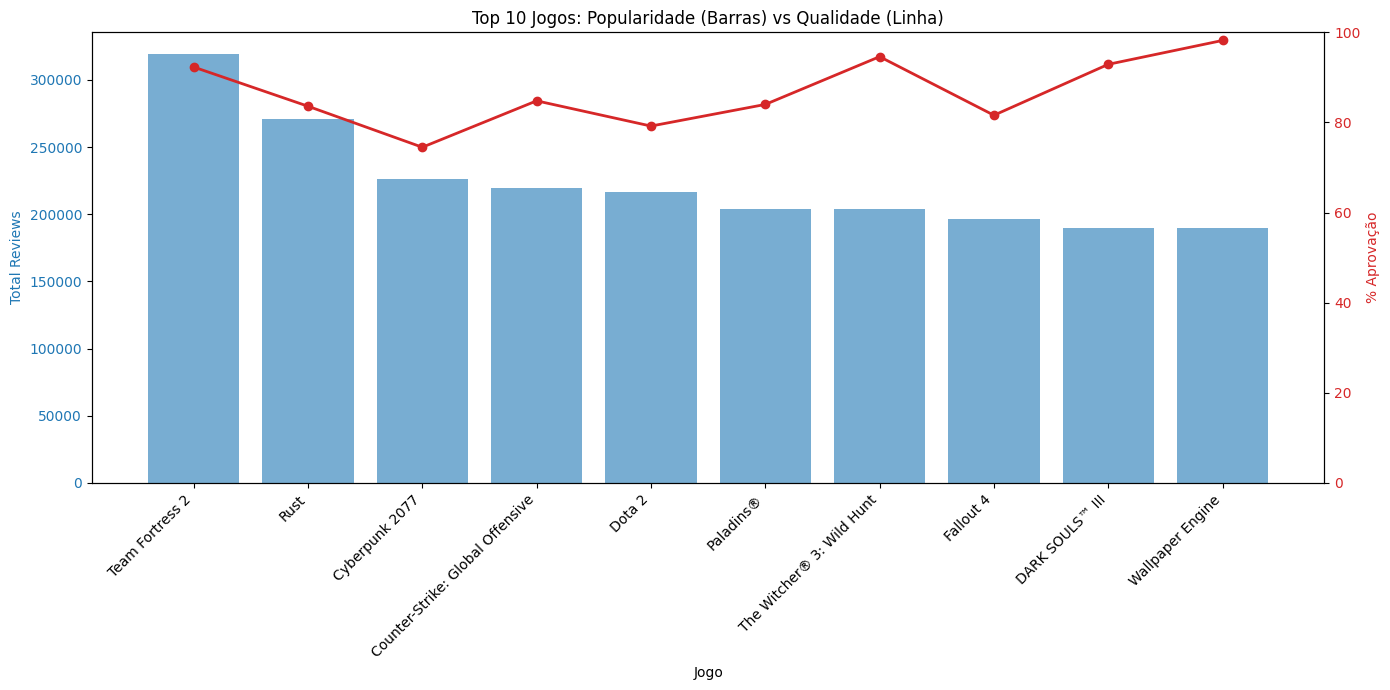

In [ ]:
# Configuração do gráfico
plt.figure(figsize=(12, 6))

# Vamos pegar apenas os Top 10 para o gráfico não ficar poluído
top_10 = pdf_gold.head(10)

# Criando um gráfico de barras duplo
x = top_10['game_title']
y1 = top_10['total_reviews']
y2 = top_10['approval_rate_percent']

fig, ax1 = plt.subplots(figsize=(14, 7))

# Eixo Y da Esquerda (Total Reviews) - Barras Azuis
ax1.bar(x, y1, color='tab:blue', alpha=0.6, label='Total Reviews')
ax1.set_xlabel('Jogo')
ax1.set_ylabel('Total Reviews', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
plt.xticks(rotation=45, ha='right') # Rotacionar nomes dos jogos

# Eixo Y da Direita (Aprovação %) - Linha Vermelha
ax2 = ax1.twinx()
ax2.plot(x, y2, color='tab:red', marker='o', linewidth=2, label='% Aprovação')
ax2.set_ylabel('% Aprovação', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, 100) # Fixar escala de 0 a 100%

plt.title('Top 10 Jogos: Popularidade (Barras) vs Qualidade (Linha)')
plt.tight_layout()
plt.show()

Exportar para Excel (.xlsx)

In [ ]:
# Instala biblioteca necessária para Excel (se não tiver)
!pip install openpyxl

import pandas as pd

# 1. Carregar os dados Gold do Data Lake (se já não estiverem na memória)
df_gold = spark.read.format("delta").load("/tmp/lakehouse/gold/top_games_report")

# 2. Converter para Pandas
# Como são apenas 50 linhas, é extremamente rápido e seguro para a memória RAM
pdf_gold = df_gold.toPandas()

# 3. Salvar como Excel
output_excel = "relatorio_top_games.xlsx"
pdf_gold.to_excel(output_excel, index=False, sheet_name="Top 50 Steam Games")

print(f"Arquivo '{output_excel}' gerado com sucesso!")
# Se estiver no Google Colab, use o comando abaixo para baixar para seu PC:
# from google.colab import files
# files.download(output_excel)

Arquivo 'relatorio_top_games.xlsx' gerado com sucesso!
